In [143]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import seaborn as sns

Firstly, we need to set our parameters. What type of distributions do we use?

## Econ Courses

For EC100, appears to be a normal distribution with mean ~ 67, SD ~ 10.5.

![images/EC100.png](images/EC100.png)

EC102 has varied a lot more YoY, for reasons I am not too sure about. Pre-COVID, average was 65, post-COVID is 68-69. SD around 12.

![images/EC102.png](images/EC102.png)

## Maths Department

MA100: seems to be very flat distribution, with varying means. Before COVID, mean was around 60%. Now 67% or more, 72% in 2021. SD 19 pre-COVID, 14 post-COVID.

![images/MA100.png](images/MA100.png)

MA107: mean around 68, SD around 17.

![images/MA107.png](images/MA107.png)

## Statistics

For ST102, there was an anomaly in 2019/20. Otherwise, mean is 68, SD is 15-19 (say 17).

![images/ST102.png](images/ST102.png)

Based on the above, we set the variables below. That said, it really shouldn't matter. We can see that a lot of these distributions are roughly normal.

Clear trends during online exams:
- Greater $\mu$, could be do to with 'easier' exams or collaboration increasing scores for some.
- A smaller $\sigma$ - less variance with the higher mean also means more people getting a first.

In [144]:
mean = 67
stdev = 14
n = 1000
first_mark = 70

In [145]:
# we can create a 'random' normal distribution to simulate n people taking exams.
norm_exam = stats.norm.rvs(size = n, loc = mean, scale = stdev)

# need to ensure that the values are within the parameters of our discussion; that is, exam score must be b/w 0 and 100. - this implementation might be slightly statistically flawed. alternative is to set all values below 0 to 0, all values above 100 to 100. 
for score in np.nditer(norm_exam, op_flags=['readwrite']):
    while score > 100.0:
        x = stats.norm.rvs(loc = mean, scale = stdev, size = 1)
        score[...] = np.mean(x)
    while score <0:
        x = stats.norm.rvs(loc = mean, scale = stdev, size = 1)
        score[...] = np.mean(x)


Text(0.5, 0, 'Exam Score')

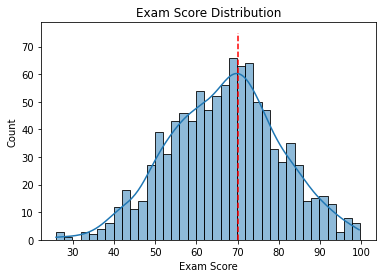

In [163]:
norm_exam_plt = sns.histplot(x=norm_exam, binwidth = 2, kde = True, stat='count', label = 'Exam Dist')
plt.vlines(first_mark, 0, 75, color='r', label='First', colors="r", linestyles='dashed')
plt.title('Exam Score Distribution')
plt.xlabel('Exam Score')

Extract the KDE so that we can calculate cumulative distributions and the like.

In [147]:
x = np.sort(norm_exam)
cdf_values = np.arange(n) / n
first_cdf = 1 - np.interp(70,x, cdf_values)
print(first_cdf)

0.41723256936815256


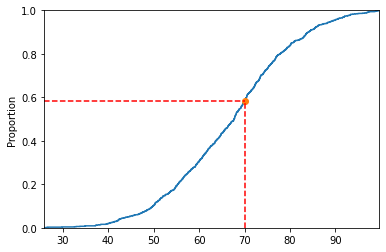

In [148]:
sns.ecdfplot(data=norm_exam)
# plt.vlines(first_mark, 0, 1, color='r', label='First', colors="r", linestyles='dashed')
plt.plot([first_mark], [1-first_cdf], marker = 'o')
plt.hlines(y=1-first_cdf, xmin=np.interp(0, cdf_values, x), xmax=first_mark,colors='red',linestyles='dashed')
plt.vlines(x=first_mark, ymin=0, ymax = 1-first_cdf, colors= 'red', linestyles='dashed')
plt.margins(0)

around 40% of students get a first with our current $\mu$ and $\sigma$

With COVID, it seems we have two trends:
- first, there has been an increase in the $\mu$. This is possibly because of ease of exams now that students have access to course materials, but it may also be due to academic dishonesty - for example, as students collaborate, they bring up poorer performing student, or might be able to write better-prepared answers. It may also be a case of 'divide and conquer.'
- Secondly, we see a lower SD. Access to course materials may mean lower threshold for writing good answers. There is also more time which will benefit those who are not as 'quick-thinking.' And as above, poorer-performing students who collaborate will be given a bridge to a better score, lowering the variance.

To incorporate this into our model, we can create two distributions - one for standard students (with the preexisting mean and variance), and one for cheaters. We can assume an $x$ proportion of students cheat on their exams.

In [149]:
prop_cheats = 0.2

In [150]:
cheat_mean = mean*1.15
cheat_stdev = stdev*0.7

# simulate cheat exams
cheat_scores = stats.norm.rvs(size = round(n*prop_cheats), loc = cheat_mean, scale = cheat_stdev)

# need to ensure that the values are within the parameters of our discussion; that is, exam score must be b/w 0 and 100. - this implementation might be slightly statistically flawed. alternative is to set all values below 0 to 0, all values above 100 to 100. 
for score in np.nditer(cheat_scores, op_flags=['readwrite']):
    while score > 100.0:
        x = stats.norm.rvs(loc = cheat_mean, scale = cheat_stdev, size = 1)
        score[...] = np.mean(x)
    while score <0:
        x = stats.norm.rvs(loc = cheat_mean, scale = cheat_stdev, size = 1)
        score[...] = np.mean(x)


In [151]:
honest_scores = stats.norm.rvs(size = round((1-prop_cheats)*n), loc = mean, scale = stdev)

for score in np.nditer(honest_scores, op_flags=['readwrite']):
    while score > 100.0:
        x = stats.norm.rvs(loc = mean, scale = stdev, size = 1)
        score[...] = np.mean(x)
    while score <0:
        x = stats.norm.rvs(loc = mean, scale = stdev, size = 1)
        score[...] = np.mean(x)

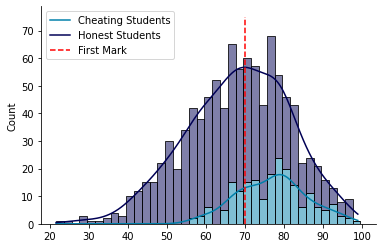

In [166]:
sns.histplot([honest_scores, cheat_scores], binwidth=2, kde=True, stat = 'count', label = 'Exam Dist', palette = 'ocean', multiple = 'stack')
plt.vlines(first_mark, 0, 75, color='r', label='First', colors="r", linestyles='dashed')
plt.legend(['Cheating Students', 'Honest Students', 'First Mark'], loc = 0)
sns.despine()

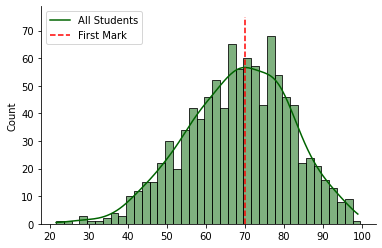

In [172]:
total_scores = np.append(honest_scores, cheat_scores)
sns.histplot(x=total_scores, binwidth=2, kde = True, stat = 'count', label = 'Exam Dist', color = 'darkgreen')
plt.vlines(first_mark, 0, 75, color='r', label='First', colors="r", linestyles='dashed')
sns.despine()
plt.legend(['All Students', 'First Mark'])

Can see now a lot more students are getting firsts! Looks like > 50%, but we can confirm below:

In [182]:
all_x = np.sort(total_scores)
all_cdf = np.arange(n) / n
all_first = 1 - np.interp(first_mark,all_x,all_cdf)

honest_x = np.sort(honest_scores)
honest_cdf = np.arange((1-prop_cheats)*n)/((1-prop_cheats)*n)
honest_first = 1- np.interp(first_mark, honest_x, honest_cdf)

cheat_x = np.sort(cheat_scores)
cheat_cdf = np.arange((prop_cheats)*n)/((prop_cheats)*n)
cheat_first = 1- np.interp(first_mark, cheat_x, cheat_cdf)

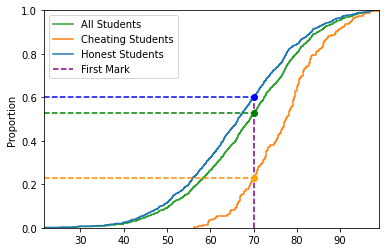

In [213]:
sns.ecdfplot([honest_scores,cheat_scores, total_scores])
plt.vlines(x=first_mark, ymin=0, ymax = 1-honest_first, colors= 'purple', linestyles='dashed')
plt.hlines(y=1-all_first, xmin=np.interp(0, all_cdf, all_x), xmax=first_mark,colors='green',linestyles='dashed')
plt.hlines(y=1-honest_first, xmin=np.interp(0, all_cdf, all_x), xmax=first_mark,colors='blue',linestyles='dashed')
plt.hlines(y=1-cheat_first, xmin=np.interp(0, all_cdf, all_x), xmax=first_mark,colors='darkorange',linestyles='dashed')
plt.plot([first_mark], [1-all_first], marker = 'o', color = 'green', linestyle = 'dashed')
plt.plot([first_mark], [1-honest_first], marker = 'o', color = 'blue', linestyle = 'dashed')
plt.plot([first_mark], [1-cheat_first], marker = 'o', color = 'orange', linestyle = 'dashed')
plt.margins(0)
plt.legend(['All Students','Cheating Students','Honest Students', 'First Mark'])
